In [1]:
import argparse

def args_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument('--epochs', type=int, default=4000, help="rounds of training")

    #嵌入向量的训练轮次
    parser.add_argument('--emb_train_epochs', type=int, default=500, help="rounds of training")
    parser.add_argument('--emb', default=True)
    
    #验证RL和Fedavg哪个更好的验证轮次
    parser.add_argument('--validation_epochs', type=int, default=10, help="rounds of training")
    
    #有多少个local client
    parser.add_argument('--num_users', type=int, default=100, help="number of users: K")
    
    #每次选多少个local client参与训练
    parser.add_argument('--frac', type=float, default=0.1, help="the fraction of clients: C")
    
    #local client自己本地训练的轮次
    parser.add_argument('--local_emb_ep', type=int, default=1, help="the number of local epochs: E")
    parser.add_argument('--local_ep', type=int, default=10, help="the number of local epochs: E")
    parser.add_argument('--local_chosen_ep', type=int, default=3, help="the number of local epochs: E")
    
    #local client本地训练的batchsize
    parser.add_argument('--local_bs', type=int, default=10, help="local batch size: B")
    parser.add_argument('--bs', type=int, default=128, help="test batch size")
    
    #RL的学习率和衰减率
    parser.add_argument('--lr', type=float, default=0.01, help="learning rate (default: 0.01)")
    parser.add_argument('--lr_decay', type=float, default=1, help="lr decay")
    parser.add_argument('--momentum', type=float, default=0.5, help="SGD momentum (default: 0.5)")
    parser.add_argument('--split', type=str, default='user', help="train-test split type, user or sample")

    # model arguments
    
    #使用的client 模型
    parser.add_argument('--model', type=str, default='cnn', help='model name')
    parser.add_argument('--kernel_num', type=int, default=9, help='number of each kind of kernel')
    parser.add_argument('--kernel_sizes', type=str, default='3,4,5',
                        help='comma-separated kernel size to use for convolution')
    parser.add_argument('--norm', type=str, default='batch_norm', help="batch_norm, layer_norm, or None")
    parser.add_argument('--num_filters', type=int, default=32, help="number of filters for conv nets")
    parser.add_argument('--max_pool', type=str, default='True',
                        help="Whether use max pooling rather than strided convolutions")

    # other arguments
    
    #使用的数据集
    parser.add_argument('--dataset', type=str, default='mnist', help="name of dataset")
    
    #数据集的划分是否满足独立同分布
    parser.add_argument('--iid', action='store_true', help='whether i.i.d or not')
    
    #输出的分类个数
    parser.add_argument('--num_classes', type=int, default=10, help="number of classes")
    
    #输入的图片的通道数
    parser.add_argument('--num_channels', type=int, default=1, help="number of channels of imges")
    parser.add_argument('--gpu', type=int, default=-1, help="GPU ID, -1 for CPU")
    parser.add_argument('--stopping_rounds', type=int, default=10, help='rounds of early stopping')
    parser.add_argument('--verbose', action='store_true', help='verbose print')
    parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')
    parser.add_argument('--all_clients', action='store_true', help='aggregation over all clients')
    parser.add_argument('--noise_factor', type=float, default=0.3)
#     parser.add_argument('--test_noise_factor', type=float, default=0.3)
      
    #resnet parameter
    parser.add_argument('--depth', type=int, default=38)
    parser.add_argument('--bottleneck', type=bool, default=False)
    args = parser.parse_args(args=[])
    return args

In [3]:
import pickle
from itertools import count

import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from torch.autograd import grad
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from torch.autograd import Variable

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import random
from torchvision import datasets, transforms
from collections import deque
  
from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from models.OriginalUpdate import LocalUpdate
from models.Update_noise_embtest_cwl import LocalUpdateNoise as LocalUpdateNoise
from models.Nets import MLP, CNNMnist, CNNCifar, CNNMnistEmbcwl
from models.Fed import FedAvg
from models.test import test_img
from models.resnet import ResNet

# parse args
args = args_parser()
args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

In [4]:
# load dataset and split users
if args.dataset == 'mnist':
    trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.repeat(1,1,1))])
    dataset_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=trans_mnist)
    dataset_test = datasets.MNIST('./data/mnist/', train=False, download=True, transform=trans_mnist)
    # sample users
    args.iid = False
    if args.iid:
        dict_users = mnist_iid(dataset_train, args.num_users)
    else:
        dict_users = mnist_noniid(dataset_train, args.num_users)
elif args.dataset == 'cifar':
    trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset_train = datasets.CIFAR10('./data/cifar', train=True, download=True, transform=trans_cifar)
    dataset_test = datasets.CIFAR10('./data/cifar', train=False, download=True, transform=trans_cifar)
    args.iid = True
    if args.iid:
        dict_users = cifar_iid(dataset_train, args.num_users)
    else:
        exit('Error: only consider IID setting in CIFAR10')
else:
    exit('Error: unrecognized dataset')
img_size = dataset_train[0][0].shape

# build model
if args.model == 'cnn' and args.dataset == 'cifar':
    net_glob = CNNCifar(args=args).to(args.device)
elif args.model == 'cnn' and args.dataset == 'mnist':
    net_glob = CNNMnist(args=args).to(args.device)
elif args.model == 'resnet' and args.dataset == 'cifar':
    net_glob = ResNet(args=args).to(args.device)
elif args.model == 'mlp':
    len_in = 1
    for x in img_size:
        len_in *= x
    net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
else:
    exit('Error: unrecognized model')
print(net_glob)
net_glob.train()

# copy weights
w_glob = net_glob.state_dict()

CNNMnist(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [5]:
class MemoryBuffer: # MemoryBuffer类实现的功能：buffer内采样，往buffer里塞（sars）

    def __init__(self, size):
        self.buffer = deque(maxlen=size) #buffer设置为双端队列
        self.maxSize = size
        self.len = 0
        
    def state_reco(self, s):
        s_1 = [i[0] for i in s]
        s_2 = [i[1] for i in s]
        s_3 = [i[2] for i in s]
        return [torch.cat(s_1),torch.cat(s_2),torch.cat(s_3)]

    def sample(self, count):
        """
        samples a random batch from the replay memory buffer
        :param count: batch size
        :return: batch (numpy array)
        """
        batch = []
        count = min(count, self.len)
        batch = random.sample(self.buffer, count) # 随机取样

        s_arr = [arr[0] for arr in batch]
        a_arr = torch.cat([arr[1] for arr in batch])
        r_arr = torch.tensor([arr[2] for arr in batch]).reshape(-1,1)
        s1_arr = [arr[3] for arr in batch]

        return self.state_reco(s_arr), a_arr, r_arr, self.state_reco(s1_arr)

    def len(self):
        return self.len

    def add(self, s, a, r, s1):
        """
        adds a particular transaction in the memory buffer
        :param s: current state
        :param a: action taken
        :param r: reward received
        :param s1: next state
        :return:
        """
        transition = (s,a,r,s1)
        self.len += 1
        if self.len > self.maxSize:
            self.len = self.maxSize
        self.buffer.append(transition)

In [6]:
class Actor(nn.Module):
    def __init__(self, parameter_dim, loss_dim, action_dim, args, min_log_std=-20, max_log_std=2):
        super(Actor, self).__init__()
        self.args = args
        self.parameter_dim = parameter_dim
        self.loss_dim = loss_dim
        self.action_dim = action_dim
        
        self.fc1 = nn.Linear(parameter_dim, 32)
        self.fc2 = nn.Linear(32*(int(args.num_users*args.frac)), 64)

        self.mu_head = nn.Linear(64, 1)
        self.log_std_head = nn.Linear(64, 1)

        self.min_log_std = min_log_std
        self.max_log_std = max_log_std
        
    def forward(self, parameters, last_loss, last_weight):
        parameter_lst = []
        for i in range(self.action_dim):
            parameter_lst.append(self.fc1(parameters[:,i,:]))
        parameter_layer = torch.cat(parameter_lst,dim=1)
#         x = torch.cat([parameter_layer,last_loss, last_weight],dim=1)
        x = parameter_layer
        x = F.relu(self.fc2(x)) # 256
        mu = self.mu_head(x)
        log_std_head = F.relu(self.log_std_head(x))
        log_std_head = torch.clamp(log_std_head, self.min_log_std, self.max_log_std)
        return mu, log_std_head


class Critic(nn.Module):
    def __init__(self, parameter_dim, loss_dim, action_dim, args):
        super(Critic, self).__init__()
        self.args = args
        self.parameter_dim = parameter_dim
        self.loss_dim = loss_dim
        self.action_dim = action_dim
        
        self.fc1 = nn.Linear(parameter_dim, 32)
        self.fc2 = nn.Linear(32*(int(args.num_users*args.frac)), 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, parameters, last_loss, last_weight):
        parameter_lst = []
        for i in range(self.action_dim):
            parameter_lst.append(self.fc1(parameters[:,i,:]))
        parameter_layer = torch.cat(parameter_lst,dim=1)
#         x = torch.cat([parameter_layer,last_loss, last_weight],dim=1)
        x = parameter_layer
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class Q(nn.Module):
    def __init__(self, parameter_dim, loss_dim, action_dim, args):
        super(Q, self).__init__()
        self.args = args
        self.parameter_dim = parameter_dim
        self.loss_dim = loss_dim
        self.action_dim = action_dim

        self.fc1 = nn.Linear(parameter_dim, 32)

        self.fc2 = nn.Linear(32*(int(args.num_users*args.frac)), 1)

    def forward(self, parameters, last_loss, last_weight, action):
        parameter_lst = []
        for i in range(self.action_dim):
            parameter_lst.append(self.fc1(parameters[:,i,:]))
        parameter_layer = torch.cat(parameter_lst,dim=1)
#         x = torch.cat([parameter_layer, last_loss, last_weight, action], dim=1)
        x = parameter_layer
        q = self.fc2(x)

        return q

In [7]:
GAMMA=0.95
TRAINING_EPOCH = 3
BATCH_SIZE = 40

class Trainer():
    def __init__(self, parameter_dim, loss_dim, action_dim, replay_buffer, args):
        super(Trainer, self).__init__()
        self.parameter_dim = parameter_dim
        self.loss_dim = loss_dim
        self.action_dim = action_dim
        self.replay_buffer = replay_buffer
        self.iter = 0
        self.loss_critic_save = []
        self.loss_actor_save = []
        self.loss_Q_save = []
        
        # 4个网络，其中三个要更新，critic_target用critic进行软更新
        self.policy_net = Actor(self.parameter_dim, 
                                 self.loss_dim, 
                                 self.action_dim, args).to(args.device)
        self.value_net = Critic(self.parameter_dim, 
                                 self.loss_dim, 
                                 self.action_dim, args).to(args.device)
        self.Q_net = Q(self.parameter_dim, 
                                 self.loss_dim, 
                                 self.action_dim, args).to(args.device)
        self.Target_value_net = Critic(self.parameter_dim, 
                                 self.loss_dim, 
                                 self.action_dim, args).to(args.device)

        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=0.001)
        self.value_optimizer = optim.Adam(self.value_net.parameters(), lr=0.001)
        self.Q_optimizer = optim.Adam(self.Q_net.parameters(), lr=0.001)
        self.num_training = 1
        
        self.value_criterion = nn.MSELoss()
        self.Q_criterion = nn.MSELoss()

        self.hard_update(self.Target_value_net, self.value_net)

    def soft_update(self, target, source, tau):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - tau) + param.data * tau
            )
    def hard_update(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
                target_param.data.copy_(param.data)
                
    def select_action(self, parameters, last_loss, last_weight):
        mu, log_sigma = self.policy_net(parameters, last_loss, last_weight)
        sigma = torch.exp(log_sigma)
        dist = Normal(mu, sigma)
        
        l = []
        for i in range(self.action_dim):
            z = dist.sample()
            l.append(torch.tanh(z).detach().cpu().numpy())
        l = torch.tensor(l).squeeze(1).squeeze(1)
        v = F.softmax(l, dim=0)
        return v # return a tensor

    def get_action_log_prob(self, parameters, last_loss, last_weight):
        min_Val = torch.tensor(1e-7).float()
        
        batch_mu, batch_log_sigma = self.policy_net(parameters, last_loss, last_weight)
        batch_sigma = torch.exp(batch_log_sigma)
        dist = Normal(batch_mu, batch_sigma) # batch_size, batch_size
        
        l = []

        for i in range(self.action_dim):
            z = dist.sample()
            action = torch.tanh(z)
            l.append(action.detach().cpu().tolist())
            if i == 0:
                z_ = z
            else:
                z_ = torch.cat([z_, z], dim = 1)

        #batch_size * action_dim
        for i in range(BATCH_SIZE):
            tmp = []
            for j in range(self.action_dim):
                tmp.append(l[j][i])
            v = F.softmax(torch.tensor(tmp).squeeze(1),dim=0)
            if i == 0:
                action = v.unsqueeze(0)
            else:
                action = torch.cat([action, v.unsqueeze(0)], dim=0)

        tmp = dist.log_prob(z_) - torch.log(1 - action.pow(2) + torch.tensor(0.5))
        log_prob = torch.mean(tmp, dim=1)
        
#         z = dist.sample()
#         action = torch.tanh(z)
#         log_prob = dist.log_prob(z) - torch.log(1 - action.pow(2) + min_Val)
        
        return action, log_prob, z_, batch_mu, batch_log_sigma

    def optimize(self):
        """
        Samples a random batch from replay memory and performs optimization
        :return:
        """

        for i in range(TRAINING_EPOCH):
            s1,a1,r1,s2 = self.replay_buffer.sample(BATCH_SIZE)
            
            r1 = Variable(r1.float(), requires_grad=True)
            
            # targte_V
            target_value = torch.squeeze(self.Target_value_net.forward(s2[0],s2[1],s2[2]))
            # Q = r + gamma*V 无偏估计（大概是）
            next_q_value = torch.squeeze(r1) + GAMMA * target_value
            
            # 通过网络再出一个Q和V
            expected_value = torch.squeeze(self.value_net.forward(s1[0], s1[1], s1[2]))
            expected_Q = torch.squeeze(self.Q_net.forward(s1[0], s1[1], s1[2], a1))
            
            # !!!Note that the actions are sampled according to the current policy,
            # instead of replay buffer. (From original paper)
            # 再出一个soft Q
            sample_action, log_prob, z, batch_mu, batch_log_sigma = self.get_action_log_prob(s1[0], s1[1], s1[2])
            expected_new_Q = torch.squeeze(self.Q_net.forward(s1[0], s1[1], s1[2], sample_action))
            next_value = expected_new_Q - log_prob

            #critic更新
            V_loss = self.value_criterion(expected_value, next_value.detach())  # J_V
            V_loss = V_loss.mean()

            
            # Single Q_net this is different from original paper!!!
            # 单独的Q网络更新
            Q_loss = self.Q_criterion(expected_Q, next_q_value.detach()) # J_Q
            Q_loss = Q_loss.mean()
            
            log_policy_target = expected_new_Q - expected_value
            
            
            #actor更新
            pi_loss = log_prob * (log_prob - log_policy_target).detach()
            pi_loss = pi_loss.mean()

            
            self.loss_actor_save.append(pi_loss)
            self.loss_Q_save.append(Q_loss)
            self.loss_critic_save.append(V_loss)
            
        
            # mini batch gradient descent
            self.value_optimizer.zero_grad()
            V_loss.backward(retain_graph=True)
            nn.utils.clip_grad_norm_(self.value_net.parameters(), 0.5)
            self.value_optimizer.step()


            self.Q_optimizer.zero_grad()
            Q_loss.backward(retain_graph = True)
            nn.utils.clip_grad_norm_(self.Q_net.parameters(), 0.5)
            self.Q_optimizer.step()

            self.policy_optimizer.zero_grad()
            pi_loss.backward(retain_graph = True)
            nn.utils.clip_grad_norm_(self.policy_net.parameters(), 0.5)
            self.policy_optimizer.step()

            # soft update
            self.soft_update(self.Target_value_net, self.value_net, 0.001)

            self.num_training += 1

    def save(self):
        torch.save(self.policy_net.state_dict(), './SAC_model/policy_net.pth')
        torch.save(self.value_net.state_dict(), './SAC_model/value_net.pth')
        torch.save(self.Q_net.state_dict(), './SAC_model/Q_net.pth')
        print("====================================")
        print("Model has been saved...")
        print("====================================")

    def load(self):
        torch.load(self.policy_net.state_dict(), './SAC_model/policy_net.pth')
        torch.load(self.value_net.state_dict(), './SAC_model/value_net.pth')
        torch.load(self.Q_net.state_dict(), './SAC_model/Q_net.pth')
        print()
        
    def valid_critic(self):
        s1,a1,r1,s2 = self.replay_buffer.sample(BATCH_SIZE)

        r1 = Variable(r1.float(), requires_grad=True)
        
        q = self.Q_net.forward(s1[0], s1[1], s1[2], a1)
        print(self.Q_criterion(q, r1))

In [8]:
def weight_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
         torch.nn.init.xavier_normal_(m.weight.data)
         torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('Linear') != -1:
         torch.nn.init.xavier_normal_(m.weight)
         torch.nn.init.constant_(m.bias, 0.0)

In [9]:
layer_name = []
count = 0
for name in w_glob.keys():
    if count % 2 == 0:
        layer_name.append(name.split('.',1)[0])
    count += 1
    
parameter_cnn = None
for i in layer_name:
    if parameter_cnn is None:
        parameter_cnn = torch.cat([w_glob[i + '.weight'].reshape(1, -1),
                                   w_glob[i + '.bias'].reshape(1, -1)], 1)
    else:
        parameter_cnn = torch.cat([parameter_cnn,
                                   w_glob[i + '.weight'].reshape(1, -1),
                                   w_glob[i + '.bias'].reshape(1, -1)], 1)
Emb_Net = CNNMnistEmbcwl(parameter_cnn.numel(), args)

optimizer = torch.optim.Adam([{'params':Emb_Net.parameters()}], 0.001)
criterion = nn.MSELoss(reduction='mean')

In [ ]:
loss_save = []
loss1_save = []
loss2_save = []

if args.model == 'cnn' and args.dataset == 'cifar':
    net_glob = CNNCifar(args=args).to(args.device)
elif args.model == 'cnn' and args.dataset == 'mnist':
    net_glob = CNNMnist(args=args).to(args.device)
elif args.model == 'mlp':
    len_in = 1
    for x in img_size:
        len_in *= x
    net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
else:
    exit('Error: unrecognized model')
net_glob.train()

noise_num = 50
last_parameter = {}

for iter in range(args.emb_train_epochs):
    w_locals = []
    if iter % 20 == 0:
        net_glob.apply(weight_init)
        net_glob.train()
    parameter_cnn_list = []
    noise_flag = None
    noise_idx = np.random.choice(range(args.num_users), 50, replace=False)
    idxs = np.random.choice(range(args.num_users), 100, replace=False)
    if args.noise_factor == 1:
        arg.noise_factor = 0.3
    args.noise_factor += 0.1
    for idx in idxs:
        if idx in noise_idx:
            add_noise = True
        else:
            add_noise = False
        local = LocalUpdateNoise(args=args, dataset=dataset_train, idxs=dict_users[idx],
                                add_noise=add_noise, flag=True, noise_num=noise_num)
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
        w_locals.append(copy.deepcopy(w))
        parameter_cnn = None
        for i in layer_name:
            if parameter_cnn is None:
                parameter_cnn = torch.cat([w[i + '.weight'].reshape(1, -1),
                                           w[i + '.bias'].reshape(1, -1)], 1)
            else:
                parameter_cnn = torch.cat([parameter_cnn,
                                           w[i + '.weight'].reshape(1, -1),
                                           w[i + '.bias'].reshape(1, -1)], 1)
        parameter_cnn_list.append(parameter_cnn)
        #######################部分加入“加入噪音”标记############################
        if not add_noise:
            if noise_flag is None:
                noise_flag = torch.ones((1, 1))
            else:
                noise_flag = torch.cat([noise_flag, torch.ones((1, 1))], 0)
        else:
            if noise_flag is None:
                noise_flag = torch.zeros((1, 1))
            else:
                noise_flag = torch.cat([noise_flag, torch.zeros((1, 1))], 0)
        #######################部分加入“加入噪音”标记############################
    w_avg_glob = FedAvg(w_locals)
    net_glob.load_state_dict(w_avg_glob)
    parameter_cnn_final = torch.cat(parameter_cnn_list, 0)

    emb_cnn = Emb_Net.forward(parameter_cnn_final)
    predict_noise = Emb_Net.forward2(emb_cnn)
#     transform_w = Emb_Net.Reverse_raw_emb(emb_cnn)
#     loss1 = criterion(transform_w.reshape(-1, 1), parameter_cnn_final.reshape(-1, 1))
    loss2 = criterion(noise_flag, predict_noise)
#     print(noise_flag)
#     print(predict_noise)
#     loss = loss1 + loss2
    loss = loss2
    optimizer.zero_grad()
    # loss.backward(retain_graph=True)
    loss.backward()
    optimizer.step()
    print('epoch:{}, loss_avg:{}'.format(iter, loss))
#     print('loss1', loss1)
#     print('loss2', loss2)
    loss_save.append(loss)
#     loss1_save.append(loss1)
#     loss2_save.append(loss2)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch:0, loss_avg:0.2519413232803345
epoch:1, loss_avg:0.305988073348999
epoch:2, loss_avg:0.25328031182289124
epoch:3, loss_avg:0.2673618197441101
epoch:4, loss_avg:0.25722649693489075
epoch:5, loss_avg:0.2449151873588562
epoch:6, loss_avg:0.25063830614089966
epoch:7, loss_avg:0.24618427455425262
epoch:8, loss_avg:0.2564595937728882
epoch:9, loss_avg:0.24965843558311462
epoch:10, loss_avg:0.24965374171733856
epoch:11, loss_avg:0.2486656904220581
epoch:12, loss_avg:0.2526990473270416
epoch:13, loss_avg:0.24903319776058197
epoch:14, loss_avg:0.24671031534671783
epoch:15, loss_avg:0.24929511547088623
epoch:16, loss_avg:0.2445763796567917
epoch:17, loss_avg:0.24451357126235962
epoch:18, loss_avg:0.24813972413539886
epoch:19, loss_avg:0.2448463886976242
epoch:20, loss_avg:0.2482229620218277
epoch:21, loss_avg:0.23930129408836365
epoch:22, loss_avg:0.2417335957288742
epoch:23, loss_avg:0.2474038302898407
epoch:24, loss_avg:0.22902563214302063
epoch:25, loss_avg:0.24245811998844147
epoch:26,

epoch:210, loss_avg:0.06643742322921753
epoch:211, loss_avg:0.10340367257595062
epoch:212, loss_avg:0.14895139634609222
epoch:213, loss_avg:0.06670455634593964
epoch:214, loss_avg:0.15312667191028595
epoch:215, loss_avg:0.18328973650932312
epoch:216, loss_avg:0.06985966861248016
epoch:217, loss_avg:0.1264389157295227
epoch:218, loss_avg:0.1489579975605011
epoch:219, loss_avg:0.08304736018180847
epoch:220, loss_avg:0.04529324173927307
epoch:221, loss_avg:0.0065247295424342155
epoch:222, loss_avg:0.011253032833337784
epoch:223, loss_avg:0.07674041390419006
epoch:224, loss_avg:0.06713587045669556
epoch:225, loss_avg:0.08233346045017242
epoch:226, loss_avg:0.18966656923294067
epoch:227, loss_avg:0.04514128714799881
epoch:228, loss_avg:0.09200065582990646
epoch:229, loss_avg:0.0775231346487999
epoch:230, loss_avg:0.06300780177116394
epoch:231, loss_avg:0.12607307732105255
epoch:232, loss_avg:0.04638010635972023
epoch:233, loss_avg:0.2494107037782669
epoch:234, loss_avg:0.14134453237056732
e

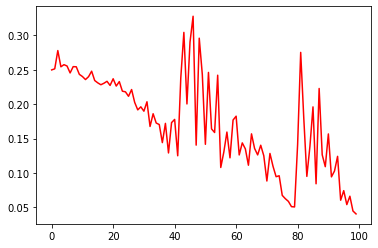

In [10]:
%matplotlib inline

plt.plot(range(len(loss_save)), loss_save, c='r')
# plt.plot(range(len(loss1_save)), loss1_save, c='b')
# plt.plot(range(len(loss2_save)), loss2_save, c='g')
plt.show()

In [10]:
Emb_Net = torch.load('./model_save/emb3.pkl')
Emb_Net.to(args.device)

CNNMnistEmbcwl(
  (layer_input): Linear(in_features=26474, out_features=512, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (layer_hidden): Linear(in_features=512, out_features=100, bias=True)
  (mlp): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU(inplace=True)
  )
  (c1_weights): Linear(in_features=128, out_features=250, bias=True)
  (c1_bias): Linear(in_features=128, out_features=10, bias=True)
  (c2_weights): Linear(in_features=128, out_features=5000, bias=True)
  (c2_bias): Linear(in_features=128, out_features=20, bias=True)
  (l1_weights): Linear(in_features=128, out_features=16000, bias=True)
  (l1_bias): Linear(in_features=128, out_features=50, bias=True)
  (l2_weights): Linear(in_features=128, out_features=500, bias=True)
  (l2_bias): Linear(in_features=128, out_features=10, bias=True)
  (whether_noise1): Linear(in_features=100, out_features=32, bias=True)
  (whether_noise2): Linear(in_features=32, out_features

In [11]:
from sklearn.manifold import TSNE
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

args.emb = False

p_emb_collect = []
emb_array = np.array([])
net_glob.apply(weight_init)
net_glob.train()
noise_num = 50
noise_idx = np.random.choice(range(args.num_users), noise_num, replace=False)

noise_list = []
for iter in range(10):
    w_locals = []
    parameter_cnn_list = []
    for idx in range(100):
        if idx in noise_idx:
            add_noise = True
            noise_list.append(idx+iter*100)
        else:
            add_noise = False
        args.noise_factor = random.random()
        local = LocalUpdateNoise(args=args, dataset=dataset_train, idxs=dict_users[idx], 
                                add_noise=add_noise, flag=True, noise_num=noise_num)
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
        w_locals.append(w)
        ############ 储存参数 ##############
        parameter_cnn = None
        for i in layer_name:
            if parameter_cnn is None:
                parameter_cnn = torch.cat([w[i + '.weight'].reshape(1, -1),
                                           w[i + '.bias'].reshape(1, -1)], 1)
            else:
                parameter_cnn = torch.cat([parameter_cnn,
                                           w[i + '.weight'].reshape(1, -1),
                                           w[i + '.bias'].reshape(1, -1)], 1)
        emb_cnn = Emb_Net.forward(parameter_cnn)
        p_emb_collect.append(emb_cnn.detach().numpy().tolist()[0])
    w_avg_glob = FedAvg(w_locals)
    net_glob.load_state_dict(w_avg_glob)
            
emb_array_noise = np.array(p_emb_collect)
emb_all = emb_array_noise
mat1 = TSNE(n_components=2, init='pca').fit_transform(emb_all)

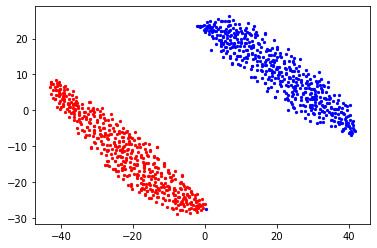

In [12]:
%matplotlib inline
x = []
y = []
x_noise = []
y_noise = []
for i in range(1000):
    if i in noise_list:
        x_noise.append(mat1[i][0])
        y_noise.append(mat1[i][1])
    else:
        x.append(mat1[i][0])
        y.append(mat1[i][1])
plt.scatter(x, y, s=5, c='b')
plt.scatter(x_noise, y_noise, s=5, c='r')
plt.show()

In [11]:
parameter_dim = 128
action_dim = 10
loss_dim = 10
replay_buffer = MemoryBuffer(500)
trainer = Trainer(parameter_dim, loss_dim, action_dim, replay_buffer, args)

In [12]:
def FedPareto(w,action):
    w_avg = copy.deepcopy(w[0])
    for k in w_avg.keys():
        for i in range(0, len(w)):
            if i==0:
                w_avg[k] = action[i] * w[i][k]
            else:
                w_avg[k] += action[i] * w[i][k]
    return w_avg

In [13]:
# training
reward_save = []

constant = 64
target_acc = 0.99
args.emb = False

last_replay_data = []

if args.model == 'cnn' and args.dataset == 'cifar':
    net_avg = CNNCifar(args=args).to(args.device)
elif args.model == 'cnn' and args.dataset == 'mnist':
    net_avg = CNNMnist(args=args).to(args.device)
elif args.model == 'mlp':
    len_in = 1
    for x in img_size:
        len_in *= x
    net_avg = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
else:
    exit('Error: unrecognized model')

noise_num = 50

# w_save = []
# for i in range(100):
#     w_save.append(net_glob.state_dict())

# for i in range(5):
#     for idx in range(100):
#         local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
#         w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
#         w_save[idx] = w
#     w_glob = FedAvg(w_save)
#     net_glob.load_state_dict(w_glob)
#     print('pretrain:', i)
# global_acc, loss_train = test_img(net_glob, dataset_test, args)
# print(global_acc)


for iter in range(args.epochs):
    if iter % 50 == 0:
        noise_idx = np.random.choice(range(args.num_users), noise_num, replace=False)
    
    if iter==0:
        random_n = 0
        n_weight = []
        while random_n < args.num_users*args.frac:
            n_weight.append(random.random()) # 随机初始化参数
            random_n += 1
        action = F.softmax(torch.tensor(n_weight))
        
    loss_locals = []
    w_locals = []
    m = max(int(args.frac * args.num_users), 1)
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
#     idxs_users = [i for i in range(10)]
    p_collect = []
    
    
    w_glob = net_glob.state_dict()
    parameter_cnn = None
    for i in layer_name:
        if parameter_cnn is None:
            parameter_cnn = torch.cat([w_glob[i + '.weight'].reshape(1, -1),
                                       w_glob[i + '.bias'].reshape(1, -1)], 1)
        else:
            parameter_cnn = torch.cat([parameter_cnn,
                                       w_glob[i + '.weight'].reshape(1, -1),
                                       w_glob[i + '.bias'].reshape(1, -1)], 1)
    emb_cnn = Emb_Net.forward(parameter_cnn)
    p_collect.append(emb_cnn) 
    
    noise_vector = []
    #只收集local，用于noise predict
    p_local_collect = []
    for idx in idxs_users:
        if idx in noise_idx:
            add_noise = True
            noise_vector.append(0)
        else:
            add_noise = False
            noise_vector.append(1)
        local = LocalUpdateNoise(args=args, dataset=dataset_train, idxs=dict_users[idx], add_noise=add_noise, flag=True, 
                                 noise_num=noise_num)
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
        ############ 储存参数 ##############
        parameter_cnn = None
        for i in layer_name:
            if parameter_cnn is None:
                parameter_cnn = torch.cat([w[i + '.weight'].reshape(1, -1),
                                           w[i + '.bias'].reshape(1, -1)], 1)
            else:
                parameter_cnn = torch.cat([parameter_cnn,
                                           w[i + '.weight'].reshape(1, -1),
                                           w[i + '.bias'].reshape(1, -1)], 1)
        emb_cnn = Emb_Net.forward(parameter_cnn)
        p_collect.append(emb_cnn)
        p_local_collect.append(emb_cnn)
        ############ 储存loss ##############
        w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
    p_collect = torch.cat(p_collect).unsqueeze(0).to(args.device) # parameter_dim * 11
    p_local_collect = torch.cat(p_local_collect).unsqueeze(0).to(args.device) # parameter_dim * 10
    #tsne
    action_next = trainer.select_action(p_collect,
                                          torch.tensor(loss_locals).reshape(1,-1).to(args.device), 
                                          action.reshape(1,-1).to(args.device)) #s = [p, loss, last_action]
    noise_predict = Emb_Net.forward2(p_local_collect)
    noise_predict = noise_predict.squeeze(0).squeeze(1)
    noise_w = noise_predict/torch.sum(noise_predict)

#     if iter % 10 == 0:
    print('epoch{}--action:{}'.format(iter, action_next))
    ###########计算当前轮的reward，然后将当前轮的reward添加到上一个replay_data中
    # update global weights
#     w_avg_glob = FedAvg(w_locals)
    w_glob = FedPareto(w_locals, action_next)
    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)
#     net_avg.load_state_dict(w_avg_glob)
    
#     reward = -sum(loss_locals) / len(loss_locals)
    net_glob.eval()
    global_acc, loss_train = test_img(net_glob, dataset_test, args)
#     avg_acc, _ = test_img(net_avg, dataset_test, args)
    print('globlal:',global_acc)
    # copy weight to net_glob
#     print('avg:',avg_acc)
    print('noise:',noise_vector)
#     print('noise_predict',noise_predict)
#     diff = global_acc.numpy() - avg_acc.numpy()
    
    alpha = 0.5
    beta = 0
    reward1 = constant ** (global_acc.numpy()/100 - target_acc) - 1
    
    #nn.MSELoss(reduction='mean')
    print('reward1', reward1)
    loss2 = nn.MSELoss(reduction='mean')
    print('noise_w', noise_w)
    reward2 = loss2(noise_predict, action_next)
#     print('reward2', reward2)
    reward = alpha*reward1 - beta*reward2
#     reward1 = constant ** (global_acc.numpy()/100 - target_acc) - 1
#     reward2 = constant ** diff - 1
#     reward =  0.7 * reward1 + 0.3 * np.clip(reward2, -1, 0)

#     reward = np.clip(constant ** diff-1, -1, 1)
#     tmp = F.softmax(torch.tensor([[float(global_acc.numpy())], [float(avg_acc.numpy())]]), dim=0)
#     reward = tmp.detach().numpy().tolist()[0][0] - 1




    reward_save.append(reward)
    
    if len(last_replay_data)==3:
#         last_replay_data.append(reward)#r
        last_replay_data.append([p_collect, 
                                 torch.tensor(loss_locals).reshape(1,-1).to(args.device), 
                                 action.reshape(1,-1).to(args.device)])#s_next
        trainer.replay_buffer.add(last_replay_data[0],
                                  last_replay_data[1],
                                  last_replay_data[2],
                                  last_replay_data[3])
    last_replay_data = [[p_collect, 
                         torch.tensor(loss_locals).reshape(1,-1).to(args.device), 
                         action.reshape(1,-1).to(args.device)], 
                        action_next.reshape(1,-1).to(args.device), reward]#s, a, r
    action = action_next

    # print loss
    print('Round {:3d}, reward {:.3f}'.format(iter, reward))
    
    if iter > 40 and iter % 40 == 0:
        trainer.optimize()
    if iter % 200 == 0:
        if args.model == 'cnn' and args.dataset == 'cifar':
            net_glob = CNNCifar(args=args).to(args.device)
        elif args.model == 'cnn' and args.dataset == 'mnist':
            net_glob = CNNMnist(args=args).to(args.device)
        elif args.model == 'mlp':
            len_in = 1
            for x in img_size:
                len_in *= x
            net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
        else:
            exit('Error: unrecognized model')
            
#     args.lr = max(args.lr*args.lr_decay, 0.001)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


TypeError: __init__() got an unexpected keyword argument 'flag'

In [ ]:
# for i in range(10):
#     trainer.valid_critic()

In [ ]:
# if args.model == 'cnn' and args.dataset == 'cifar':
#     net_glob = CNNCifar(args=args).to(args.device)
# elif args.model == 'cnn' and args.dataset == 'mnist':
#     net_glob = CNNMnist(args=args).to(args.device)
#     net_avg = CNNMnist(args=args).to(args.device)
# elif args.model == 'mlp':
#     len_in = 1
#     for x in img_size:
#         len_in *= x
#     net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
# else:
#     exit('Error: unrecognized model')

# noise_idx = [0]
# loss_locals = []
# w_locals = []
# m = max(int(args.frac * args.num_users), 1)
# idxs_users = [i for i in range(10)]
# p_collect = []
# action = F.softmax(torch.tensor(n_weight))

# for idx in idxs_users:
#     if idx in noise_idx:
#         add_noise = True
#         print('noise_idx:', idx)
#     else:
#         add_noise = False
#     local = LocalUpdateNoise(args=args, dataset=dataset_train, add_noise=add_noise, idxs=dict_users[idx], flag=False,
#                              noise_num=noise_num)
#     w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
#     ############ 储存参数 ##############
#     parameter_cnn = None
#     for i in layer_name:
#         if parameter_cnn is None:
#             parameter_cnn = torch.cat([w[i + '.weight'].reshape(1, -1),
#                                        w[i + '.bias'].reshape(1, -1)], 1)
#         else:
#             parameter_cnn = torch.cat([parameter_cnn,
#                                        w[i + '.weight'].reshape(1, -1),
#                                        w[i + '.bias'].reshape(1, -1)], 1)
#     emb_cnn = Emb_Net.forward(parameter_cnn)
#     p_collect.append(emb_cnn)
#     ############ 储存loss ##############
#     w_locals.append(copy.deepcopy(w))
#     loss_locals.append(copy.deepcopy(loss))
# p_collect = torch.cat(p_collect).unsqueeze(0).to(args.device)
# avg_q = trainer.Q_net.forward(p_collect,
#                   torch.tensor(loss_locals).reshape(1,-1).to(args.device), 
#                   action.reshape(1,-1).to(args.device), torch.tensor([0.1]*10).unsqueeze(0))
# rl_q = trainer.Q_net.forward(p_collect,
#                   torch.tensor(loss_locals).reshape(1,-1).to(args.device), 
#                   action.reshape(1,-1).to(args.device), torch.tensor([0]+[1/9]*9).unsqueeze(0))
# print('aq',avg_q)
# print('rq',rl_q)

# w_avg = FedAvg(w_locals)
# w_glob = FedPareto(w_locals, torch.tensor([0]+[1/9]*9))

# net_glob.load_state_dict(w_glob)
# net_avg.load_state_dict(w_avg)

# global_acc, loss_train = test_img(net_glob, dataset_test, args)
# avg_acc, loss_train = test_img(net_avg, dataset_test, args)
# print('aa', avg_acc)
# print('ga:', global_acc)

In [34]:
reward_validation_save = []

if args.model == 'cnn' and args.dataset == 'cifar':
    net_glob = CNNCifar(args=args).to(args.device)
elif args.model == 'cnn' and args.dataset == 'mnist':
    net_glob = CNNMnist(args=args).to(args.device)
elif args.model == 'mlp':
    len_in = 1
    for x in img_size:
        len_in *= x
    net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
else:
    exit('Error: unrecognized model')

noise_num = 50
noise_idx = np.random.choice(range(args.num_users), noise_num, replace=False)

# print('noise_idx', noise_idx[:10])

#args.validation_epochs
for iter in range(10):
    noise_label = []
    noise_idx = np.random.choice(range(args.num_users), noise_num, replace=False)
    if iter==0:
        random_n = 0
        n_weight = []
        while random_n < args.num_users*args.frac:
            n_weight.append(random.random()) # 随机初始化参数
            random_n+=1
        action = F.softmax(torch.tensor(n_weight))
    loss_locals = []
    w_locals = []
    m = max(int(args.frac * args.num_users), 1)
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
#     idxs_users = [i for i in range(10)]
    p_collect = []
      
    w_glob = net_glob.state_dict()
    parameter_cnn = None
    for i in layer_name:
        if parameter_cnn is None:
            parameter_cnn = torch.cat([w_glob[i + '.weight'].reshape(1, -1),
                                       w_glob[i + '.bias'].reshape(1, -1)], 1)
        else:
            parameter_cnn = torch.cat([parameter_cnn,
                                       w_glob[i + '.weight'].reshape(1, -1),
                                       w_glob[i + '.bias'].reshape(1, -1)], 1)
    emb_cnn = Emb_Net.forward(parameter_cnn)
    p_collect.append(emb_cnn) 
    
    p_local_collect = []
    for idx in idxs_users:
        if idx in noise_idx:
            add_noise = True
            noise_label.append(0)
#             print('noise_idx:', idx)
        else:
            add_noise = False
            noise_label.append(1)
        local = LocalUpdateNoise(args=args, dataset=dataset_train, add_noise=add_noise, idxs=dict_users[idx], flag=True,
                                 noise_num=noise_num)

        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
        ############ 储存参数 ##############
        parameter_cnn = None
        for i in layer_name:
            if parameter_cnn is None:
                parameter_cnn = torch.cat([w[i + '.weight'].reshape(1, -1),
                                           w[i + '.bias'].reshape(1, -1)], 1)
            else:
                parameter_cnn = torch.cat([parameter_cnn,
                                           w[i + '.weight'].reshape(1, -1),
                                           w[i + '.bias'].reshape(1, -1)], 1)
        emb_cnn = Emb_Net.forward(parameter_cnn)
        p_collect.append(emb_cnn)
        p_local_collect.append(emb_cnn)
        ############ 储存loss ##############
        w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
    p_collect = torch.cat(p_collect).unsqueeze(0).to(args.device)
    p_local_collect = torch.cat(p_local_collect).unsqueeze(0).to(args.device) # parameter_dim * 10
    action_next = trainer.select_action(p_collect,
                                          torch.tensor(loss_locals).reshape(1,-1).to(args.device), 
                                          action.reshape(1,-1).to(args.device)) #s = [p, loss, last_action]
    noise_predict = Emb_Net.forward2(p_local_collect)
    noise_predict = noise_predict.squeeze(0).squeeze(1)
    noise_w = noise_predict/torch.sum(noise_predict)
    print(action_next)
    print('noise_w', noise_w)
    print(noise_label)
    ###########计算当前轮的reward，然后将当前轮的reward添加到上一个replay_data中
    net_glob.eval()
    global_acc, loss_train = test_img(net_glob, dataset_test, args)
    print(global_acc)
    reward = constant ** (global_acc.numpy()/100 - target_acc) - 1
    if reward >= 0:
        print('well done')
        break

    reward_validation_save.append(reward)
    action = action_next
    # update global weights
#     w_glob = FedAvg(w_locals)
#     w_glob = FedPareto(w_locals, action_next)
    w_glob = FedPareto(w_locals, noise_w)
    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)

    # print loss
    print('Round {:3d}, Average loss {:.3f}'.format(iter, -reward))
#     loss_train.append(-reward)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([0.0231, 0.0269, 0.1705, 0.1470, 0.0744, 0.1705, 0.0238, 0.1700, 0.1705,
        0.0232])
noise_w tensor([0.1127, 0.1104, 0.1099, 0.1134, 0.1160, 0.0509, 0.1105, 0.0451, 0.1150,
        0.1163], grad_fn=<DivBackward0>)
[1, 1, 1, 1, 1, 0, 1, 0, 1, 1]
tensor(8.0200)
Round   0, Average loss 0.977
tensor([0.1238, 0.1810, 0.0245, 0.1810, 0.1810, 0.0245, 0.0257, 0.0465, 0.0311,
        0.1810])
noise_w tensor([0.1432, 0.1356, 0.0578, 0.0555, 0.1415, 0.0631, 0.0687, 0.1327, 0.0632,
        0.1387], grad_fn=<DivBackward0>)
[1, 1, 0, 0, 1, 0, 0, 1, 0, 1]
tensor(9.5800)
Round   1, Average loss 0.976
tensor([0.0275, 0.2032, 0.0279, 0.0515, 0.0275, 0.2032, 0.0275, 0.2009, 0.0275,
        0.2032])
noise_w tensor([0.0749, 0.0686, 0.0747, 0.1719, 0.1574, 0.0694, 0.0747, 0.0691, 0.0747,
        0.1644], grad_fn=<DivBackward0>)
[0, 0, 0, 1, 1, 0, 0, 0, 0, 1]
tensor(20.0700)
Round   2, Average loss 0.962
tensor([0.0297, 0.1731, 0.1692, 0.0234, 0.1731, 0.0234, 0.0234, 0.0385, 0.1731,
        0.173

In [35]:
# plot loss curve
# plt.figure()
# plt.plot(range(len(loss_train)), loss_train)
# plt.ylabel('train_loss')
# plt.show()
# plt.savefig('./save/fed_{}_{}_{}_C{}_iid{}.png'.format(args.dataset, args.model, args.epochs, args.frac, args.iid))

# testing
net_glob.eval()
acc_train, loss_train = test_img(net_glob, dataset_train, args)
acc_test, loss_test = test_img(net_glob, dataset_test, args)
print("Training accuracy: {:.2f}".format(acc_train))
print("Testing accuracy: {:.2f}".format(acc_test))

Training accuracy: 64.99
Testing accuracy: 66.25


In [ ]:
reward_save

<function matplotlib.pyplot.show(*args, **kw)>

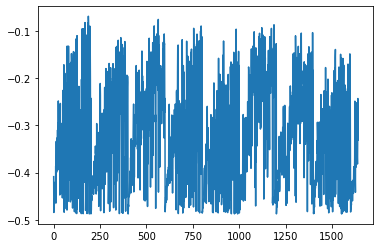

In [17]:
%matplotlib inline

plt.plot(range(len(reward_save)), reward_save)
plt.show

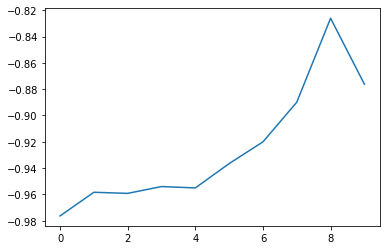

In [20]:
plt.plot(range(len(reward_validation_save)), reward_validation_save)

In [ ]:
trainer.loss_actor_save

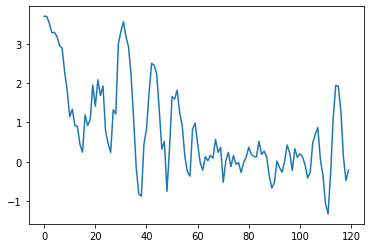

In [18]:
plt.plot(range(len(trainer.loss_actor_save)), trainer.loss_actor_save)

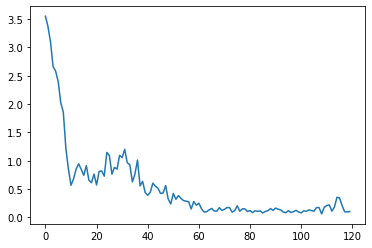

In [19]:
plt.plot(range(len(trainer.loss_critic_save)), trainer.loss_critic_save)